In [1]:
###########################################
# IMPORTS
###########################################
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools.constants import kB
from openmmtools.integrators import LangevinIntegrator

from simtk import unit, openmm

from perses.dispersed.utils import configure_platform
from perses.annihilation.lambda_protocol import RESTState, RESTCapableRelativeAlchemicalState, RESTCapableLambdaProtocol
import numpy as np
import itertools
import copy

import pickle
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import mdtraj as md

from perses.tests.test_topology_proposal import generate_dipeptide_top_pos_sys, generate_atp
from perses.annihilation.relative import RESTCapableHybridTopologyFactory


#############################################
# CONSTANTS
#############################################
temperature = 300.0 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT
REFERENCE_PLATFORM = openmm.Platform.getPlatformByName("CUDA")

DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.4.3
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections'

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


conducting subsequent work with the following platform: CUDA


INFO:rdkit:Enabling RDKit 2021.03.4 jupyter extensions


## Generate htf

In [2]:
import os
from pkg_resources import resource_filename
from perses.app import setup_relative_calculation
import pickle
from simtk import openmm, unit
from simtk.openmm import app
from openmmforcefields.generators import SystemGenerator
import numpy as np

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


In [35]:
# Test 8-mer peptide in solvent
peptide_filename = resource_filename('perses', 'data/8mer-example/4zuh_peptide_capped.pdb')
pdb = app.PDBFile(peptide_filename)
forcefield_files = ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
barostat = openmm.MonteCarloBarostat(1.0 * unit.atmosphere, 300 * unit.kelvin, 50)
modeller = app.Modeller(pdb.topology, pdb.positions)
 
system_generator = SystemGenerator(forcefields=forcefield_files,
                                   barostat=barostat,
                                   forcefield_kwargs={'removeCMMotion': False,
                                                      'ewaldErrorTolerance': 0.00025,
                                                      'constraints': app.HBonds,
                                                      'hydrogenMass': 4 * unit.amus,
                                                     'rigidWater': True},
                                   periodic_forcefield_kwargs={'nonbondedMethod': app.PME},
                                   small_molecule_forcefield='gaff-2.11',
                                   nonperiodic_forcefield_kwargs=None,
                                   molecules=None,
                                   cache=None)

modeller.addSolvent(system_generator.forcefield, model='tip3p', padding=9*unit.angstroms, ionicStrength=0.15*unit.molar)
topology = modeller.getTopology()
positions = modeller.getPositions()

# Canonicalize the solvated positions: turn tuples into np.array
positions = unit.quantity.Quantity(value=np.array([list(atom_pos) for atom_pos in positions.value_in_unit_system(unit.md_unit_system)]), unit=unit.nanometers)
system = system_generator.create_system(topology)



In [3]:
import openmmtools

In [4]:
atp = openmmtools.testsystems.AlanineDipeptideVacuum()
forcefield_files = ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
forcefield = app.ForceField(*forcefield_files)
modeller = app.Modeller(atp.topology, atp.positions)
modeller.addSolvent(forcefield, model='tip3p', padding=9*unit.angstroms, ionicStrength=0.15*unit.molar)

system = forcefield.createSystem(modeller.topology, 
                                 nonbondedMethod=app.PME, 
                                 constraints=app.HBonds, 
                                 rigidWater=True, 
                                 removeCMMotion=False, 
                                 hydrogenMass=4*unit.amu)



In [5]:
for i in range(system.getNumConstraints()):
    p1, p2, length = system.getConstraintParameters(i)
    if p1 in (22, 23, 24):
        print(p1, p2, length)
    

22 23 0.09572 nm
22 24 0.09572 nm
23 24 0.15139006545247014 nm


In [30]:
for bond in topology.bonds():
    print(bond[0], bond[1])

<Atom 1 (C) of chain 0 residue 0 (ACE)> <Atom 0 (CH3) of chain 0 residue 0 (ACE)>
<Atom 1 (C) of chain 0 residue 0 (ACE)> <Atom 2 (O) of chain 0 residue 0 (ACE)>
<Atom 0 (CH3) of chain 0 residue 0 (ACE)> <Atom 3 (H1) of chain 0 residue 0 (ACE)>
<Atom 0 (CH3) of chain 0 residue 0 (ACE)> <Atom 4 (H2) of chain 0 residue 0 (ACE)>
<Atom 0 (CH3) of chain 0 residue 0 (ACE)> <Atom 5 (H3) of chain 0 residue 0 (ACE)>
<Atom 1 (C) of chain 0 residue 0 (ACE)> <Atom 6 (N) of chain 0 residue 1 (SER)>
<Atom 8 (C) of chain 0 residue 1 (SER)> <Atom 7 (CA) of chain 0 residue 1 (SER)>
<Atom 8 (C) of chain 0 residue 1 (SER)> <Atom 9 (O) of chain 0 residue 1 (SER)>
<Atom 7 (CA) of chain 0 residue 1 (SER)> <Atom 10 (CB) of chain 0 residue 1 (SER)>
<Atom 7 (CA) of chain 0 residue 1 (SER)> <Atom 13 (HA) of chain 0 residue 1 (SER)>
<Atom 7 (CA) of chain 0 residue 1 (SER)> <Atom 6 (N) of chain 0 residue 1 (SER)>
<Atom 10 (CB) of chain 0 residue 1 (SER)> <Atom 15 (HB2) of chain 0 residue 1 (SER)>
<Atom 10 (CB) of

<Atom 1944 (O) of chain 1 residue 617 (HOH)> <Atom 1945 (H1) of chain 1 residue 617 (HOH)>
<Atom 1944 (O) of chain 1 residue 617 (HOH)> <Atom 1946 (H2) of chain 1 residue 617 (HOH)>
<Atom 1947 (O) of chain 1 residue 618 (HOH)> <Atom 1948 (H1) of chain 1 residue 618 (HOH)>
<Atom 1947 (O) of chain 1 residue 618 (HOH)> <Atom 1949 (H2) of chain 1 residue 618 (HOH)>
<Atom 1950 (O) of chain 1 residue 619 (HOH)> <Atom 1951 (H1) of chain 1 residue 619 (HOH)>
<Atom 1950 (O) of chain 1 residue 619 (HOH)> <Atom 1952 (H2) of chain 1 residue 619 (HOH)>
<Atom 1953 (O) of chain 1 residue 620 (HOH)> <Atom 1954 (H1) of chain 1 residue 620 (HOH)>
<Atom 1953 (O) of chain 1 residue 620 (HOH)> <Atom 1955 (H2) of chain 1 residue 620 (HOH)>
<Atom 1956 (O) of chain 1 residue 621 (HOH)> <Atom 1957 (H1) of chain 1 residue 621 (HOH)>
<Atom 1956 (O) of chain 1 residue 621 (HOH)> <Atom 1958 (H2) of chain 1 residue 621 (HOH)>
<Atom 1959 (O) of chain 1 residue 622 (HOH)> <Atom 1960 (H1) of chain 1 residue 622 (HOH)>

<Atom 4194 (O) of chain 1 residue 1367 (HOH)> <Atom 4195 (H1) of chain 1 residue 1367 (HOH)>
<Atom 4194 (O) of chain 1 residue 1367 (HOH)> <Atom 4196 (H2) of chain 1 residue 1367 (HOH)>
<Atom 4197 (O) of chain 1 residue 1368 (HOH)> <Atom 4198 (H1) of chain 1 residue 1368 (HOH)>
<Atom 4197 (O) of chain 1 residue 1368 (HOH)> <Atom 4199 (H2) of chain 1 residue 1368 (HOH)>
<Atom 4200 (O) of chain 1 residue 1369 (HOH)> <Atom 4201 (H1) of chain 1 residue 1369 (HOH)>
<Atom 4200 (O) of chain 1 residue 1369 (HOH)> <Atom 4202 (H2) of chain 1 residue 1369 (HOH)>
<Atom 4203 (O) of chain 1 residue 1370 (HOH)> <Atom 4204 (H1) of chain 1 residue 1370 (HOH)>
<Atom 4203 (O) of chain 1 residue 1370 (HOH)> <Atom 4205 (H2) of chain 1 residue 1370 (HOH)>
<Atom 4206 (O) of chain 1 residue 1371 (HOH)> <Atom 4207 (H1) of chain 1 residue 1371 (HOH)>
<Atom 4206 (O) of chain 1 residue 1371 (HOH)> <Atom 4208 (H2) of chain 1 residue 1371 (HOH)>
<Atom 4209 (O) of chain 1 residue 1372 (HOH)> <Atom 4210 (H1) of chain

In [5]:
from perses.rjmc.topology_proposal import PointMutationEngine
from perses.annihilation.relative import RepartitionedHybridTopologyFactory
from perses.tests.utils import validate_endstate_energies
import random

aminos = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE','LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL']

ENERGY_THRESHOLD = 1e-6
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300.0 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT

chain = 'C'
for res in topology.residues():
    if res.id == '2':
        wt_res = res.name
# aminos_updated = [amino for amino in aminos if amino not in [wt_res, 'PRO', 'HIS', 'TRP', 'PHE', 'TYR']]
# mutant = random.choice(aminos_updated)
mutant = 'THR'
print(f'Making mutation {wt_res}->{mutant}')

# Create point mutation engine to mutate residue at id 2 to random amino acid
point_mutation_engine = PointMutationEngine(wildtype_topology=topology,
                                            system_generator=system_generator,
                                            chain_id=chain,
                                            max_point_mutants=1,
                                            residues_allowed_to_mutate=['2'],  # the residue ids allowed to mutate
                                            allowed_mutations=[('2', mutant)],
                                            aggregate=True)  # always allow aggregation

# Create topology proposal
topology_proposal = point_mutation_engine.propose(current_system=system, current_topology=topology)

# Create geometry engine
from perses.rjmc.geometry import FFAllAngleGeometryEngine
geometry_engine = FFAllAngleGeometryEngine(metadata=None,
                                           use_sterics=False,
                                           n_bond_divisions=100,
                                           n_angle_divisions=180,
                                           n_torsion_divisions=360,
                                           verbose=True,
                                           storage=None,
                                           bond_softening_constant=1.0,
                                           angle_softening_constant=1.0,
                                           neglect_angles=False,
                                           use_14_nonbondeds=True)

# Create geometry proposal
new_positions, logp_proposal = geometry_engine.propose(topology_proposal, positions, beta,
                                                               validate_energy_bookkeeping=True)
logp_reverse = geometry_engine.logp_reverse(topology_proposal, new_positions, positions, beta,
                                            validate_energy_bookkeeping=True)

if not topology_proposal.unique_new_atoms:
    assert geometry_engine.forward_final_context_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.forward_final_context_reduced_potential})"
    assert geometry_engine.forward_atoms_with_positions_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's forward atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.forward_atoms_with_positions_reduced_potential})"
    vacuum_added_valence_energy = 0.0
else:
    added_valence_energy = geometry_engine.forward_final_context_reduced_potential - geometry_engine.forward_atoms_with_positions_reduced_potential

if not topology_proposal.unique_old_atoms:
    assert geometry_engine.reverse_final_context_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.reverse_final_context_reduced_potential})"
    assert geometry_engine.reverse_atoms_with_positions_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.reverse_atoms_with_positions_reduced_potential})"
    subtracted_valence_energy = 0.0
else:
    subtracted_valence_energy = geometry_engine.reverse_final_context_reduced_potential - geometry_engine.reverse_atoms_with_positions_reduced_potential


2021-11-10 12:27:36,181:(5.42s):proposal_generator:	Conducting polymer point mutation proposal...


Making mutation ALA->THR


2021-11-10 12:27:36,503:(0.32s):proposal_generator:local_atom_map: {17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23}
2021-11-10 12:27:36,505:(0.00s):proposal_generator:the mapped atom names are: [('N', 'N'), ('CA', 'CA'), ('C', 'C'), ('O', 'O'), ('CB', 'CB'), ('H', 'H'), ('HA', 'HA')]
2021-11-10 12:27:37,344:(0.84s):geometry:propose: performing forward proposal
2021-11-10 12:27:37,346:(0.00s):geometry:propose: unique new atoms detected; proceeding to _logp_propose...
2021-11-10 12:27:37,348:(0.00s):geometry:Conducting forward proposal...
2021-11-10 12:27:37,350:(0.00s):geometry:Computing proposal order with NetworkX...
2021-11-10 12:27:37,356:(0.01s):geometry:number of atoms to be placed: 7
2021-11-10 12:27:37,358:(0.00s):geometry:Atom index proposal order is [25, 29, 27, 28, 24, 30, 26]
2021-11-10 12:27:37,359:(0.00s):geometry:omitted_bonds: []
2021-11-10 12:27:37,361:(0.00s):geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old sys

conducting subsequent work with the following platform: CUDA


2021-11-10 12:27:39,625:(1.61s):geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


2021-11-10 12:27:40,227:(0.60s):geometry:There are 7 new atoms
2021-11-10 12:27:40,232:(0.01s):geometry:	reduced angle potential = 0.012110045622628995.
2021-11-10 12:27:40,372:(0.14s):geometry:	reduced angle potential = 0.42015913214046535.
2021-11-10 12:27:40,511:(0.14s):geometry:	reduced angle potential = 0.0865621289059536.
2021-11-10 12:27:40,650:(0.14s):geometry:	reduced angle potential = 0.37711493597936024.
2021-11-10 12:27:40,790:(0.14s):geometry:	reduced angle potential = 3.0564808964216974.
2021-11-10 12:27:40,930:(0.14s):geometry:	reduced angle potential = 0.6769044112772002.
2021-11-10 12:27:41,075:(0.14s):geometry:	reduced angle potential = 0.48380603071841816.
2021-11-10 12:27:41,254:(0.18s):geometry:	beginning construction of no_nonbonded final system...
2021-11-10 12:27:41,256:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
2021-11-10 12:27:41,451:(0.2

conducting subsequent work with the following platform: CUDA


2021-11-10 12:27:43,647:(2.19s):geometry:total reduced potential before atom placement: 175.9603907083175


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-11-10 12:27:45,384:(1.74s):geometry:total reduced energy added from growth system: -44.66693745999549
2021-11-10 12:27:45,386:(0.00s):geometry:final reduced energy 131.29345307568119
2021-11-10 12:27:45,388:(0.00s):geometry:sum of energies: 131.293453248322
2021-11-10 12:27:45,389:(0.00s):geometry:magnitude of difference in the energies: 1.7264083140844377e-07
2021-11-10 12:27:45,390:(0.00s):geometry:Final logp_proposal: 51.56857444514255
2021-11-10 12:27:45,475:(0.08s):geometry:logp_reverse: performing reverse proposal
2021-11-10 12:27:45,477:(0.00s):geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
2021-11-10 12:27:45,479:(0.00s):geometry:Conducting forward proposal...
2021-11-10 12:27:45,480:(0.00s):geometry:Computing proposal order with NetworkX...
2021-11-10 12:27:45,486:(0.01s):geometry:number of atoms to be placed: 3
2021-11-10 12:27:45,488:(0.00s):geometry:Atom index proposal order is [25, 26, 24]
2021-11-10 12:27:45,489:(0.00s):geometry:omit

added energy components: [('CustomBondForce', 0.42032151246718025), ('CustomAngleForce', 8.976850991429115), ('CustomTorsionForce', 11.31226057841011), ('CustomBondForce', -65.3763705423019)]


2021-11-10 12:27:45,891:(0.40s):geometry:creating growth system...
2021-11-10 12:27:45,963:(0.07s):geometry:	creating bond force...
2021-11-10 12:27:45,965:(0.00s):geometry:	there are 61 bonds in reference force.
2021-11-10 12:27:45,968:(0.00s):geometry:	creating angle force...
2021-11-10 12:27:45,969:(0.00s):geometry:	there are 218 angles in reference force.
2021-11-10 12:27:45,973:(0.00s):geometry:	creating torsion force...
2021-11-10 12:27:45,975:(0.00s):geometry:	creating extra torsions force...
2021-11-10 12:27:45,977:(0.00s):geometry:	there are 399 torsions in reference force.
2021-11-10 12:27:45,980:(0.00s):geometry:	creating nonbonded force...
2021-11-10 12:27:45,982:(0.00s):geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
2021-11-10 12:27:45,984:(0.00s):geometry:		creating nonbonded exception force (i.e. custom bond for 1,4s)...
2021-11-10 12:27:45,985:(0.00s):geometry:		looping through exceptions calculating growth indices, and

conducting subsequent work with the following platform: CUDA


2021-11-10 12:27:46,466:(0.35s):geometry:setting atoms_with_positions context old positions
2021-11-10 12:27:46,767:(0.30s):geometry:There are 3 new atoms
2021-11-10 12:27:46,771:(0.00s):geometry:	reduced angle potential = 9.561051668715153e-06.


conducting subsequent work with the following platform: CUDA


2021-11-10 12:27:46,913:(0.14s):geometry:	reduced angle potential = 2.233125127093818e-08.
2021-11-10 12:27:47,050:(0.14s):geometry:	reduced angle potential = 9.265637866968462e-06.
2021-11-10 12:27:47,227:(0.18s):geometry:	beginning construction of no_nonbonded final system...
2021-11-10 12:27:47,229:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
2021-11-10 12:27:47,422:(0.19s):geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-11-10 12:27:47,423:(0.00s):geometry:	there are 61 bond forces in the no-nonbonded final system
2021-11-10 12:27:47,425:(0.00s):geometry:	there are 218 angle forces in the no-nonbonded final system
2021-11-10 12:27:47,426:(0.00s):geometry:	there are 399 torsion forces in the no-nonbonded final system
2021-11-10 12:27:47,428:(0.00s):geometry:rever

conducting subsequent work with the following platform: CUDA


2021-11-10 12:27:48,205:(0.78s):geometry:total reduced potential before atom placement: 175.96039070831753


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-11-10 12:27:49,118:(0.91s):geometry:total reduced energy added from growth system: 8.408232121515892
2021-11-10 12:27:49,121:(0.00s):geometry:final reduced energy 184.36862257769684


conducting subsequent work with the following platform: CUDA
added energy components: [('CustomBondForce', 0.0), ('CustomAngleForce', 0.0002510720441237524), ('CustomTorsionForce', 0.0286578150103797), ('CustomBondForce', 8.379323234461388)]


2021-11-10 12:27:49,123:(0.00s):geometry:sum of energies: 184.3686228298334
2021-11-10 12:27:49,125:(0.00s):geometry:magnitude of difference in the energies: 2.5213658538802974e-07
2021-11-10 12:27:49,126:(0.00s):geometry:Final logp_proposal: -27354.258993473726


In [6]:
htf = RESTCapableHybridTopologyFactory(topology_proposal=topology_proposal,
                     current_positions=positions,
                     new_positions=new_positions,
                     generate_htf_for_testing=True
                    )

2021-11-10 12:28:12,767:(23.64s):relative:*** Generating RESTCapableHybridTopologyFactory ***
2021-11-10 12:28:12,954:(0.19s):relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
2021-11-10 12:28:12,956:(0.00s):relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
2021-11-10 12:28:12,959:(0.00s):relative:No unknown forces.
2021-11-10 12:28:12,962:(0.00s):relative:r_cutoff is 1.0 nm
2021-11-10 12:28:12,964:(0.00s):relative:alpha_ewald is 2.7569734238004693
2021-11-10 12:28:12,966:(0.00s):relative:w_scale is 0.1
2021-11-10 12:28:12,968:(0.00s):relative:Set w_scale to 0 for testing
2021-11-10 12:28:12,970:(0.00s):relative:Creating hybrid system
2021-11-10 12:28:12,973:(0.00s):relative:Adding and mapping old atoms to hybrid system...
2021-11-10 12:28:13,015:(0.04s):relative:Adding and mapping new atoms to 

In [7]:
with open("8mer_solvent_scale_region.pickle", "wb") as f:
    pickle.dump(htf, f)

# Run vanilla MD on ala dipeptide at lambda = 0

In [2]:
with open("atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions
    box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()



INFO:rdkit:Enabling RDKit 2021.03.4 jupyter extensions


In [3]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


1.0
1.0
0.0


In [4]:
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [5]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [6]:
energies, positions_old, positions_new = [], [], []

for _ in tqdm_notebook(range(1000)):
    integrator.step(250) 
    
    # Get energy and positions
    state = context.getState(getEnergy=True, getPositions=True)
    energies.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
    pos = state.getPositions(asNumpy=True)
    old_pos = np.asarray(htf.old_positions(pos))
    new_pos = np.asarray(htf.new_positions(pos))
    positions_old.append(old_pos)
    positions_new.append(new_pos)
    

/scratch/lsftmp/4045571.tmpdir/ipykernel_333590/1679595699.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
with open("ala_lambda_0_energies.npy", "wb") as f:
    np.save(f, energies)

with open("ala_lambda_0_old.npy", "wb") as f:
    np.save(f, positions_old)

with open("ala_lambda_0_new.npy", "wb") as f:
    np.save(f, positions_new)
    

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

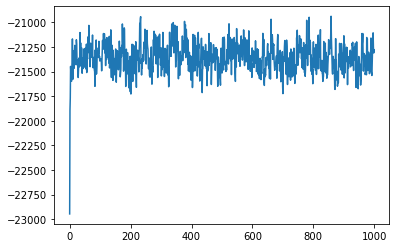

In [20]:
plt.plot(energies)
plt.show()


# Run vanilla MD on ala dipeptide at lambda = 0.5

In [8]:
with open("atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions
    box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()



In [9]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0.5
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


0.7071067811865476
0.5
0.5


In [10]:
# Get energy
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [11]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [ ]:
energies, positions_old, positions_new = [], [], []

for _ in tqdm_notebook(range(1000)):
    integrator.step(250) 
    
    # Get energy and positions
    state = context.getState(getEnergy=True, getPositions=True)
    energies.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
    pos = state.getPositions(asNumpy=True)
    old_pos = np.asarray(htf.old_positions(pos))
    new_pos = np.asarray(htf.new_positions(pos))
    positions_old.append(old_pos)
    positions_new.append(new_pos)
    

/scratch/lsftmp/4043752.tmpdir/ipykernel_61267/1679595699.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
with open("ala_lambda_0.5_energies.npy", "wb") as f:
    np.save(f, energies)

with open("ala_lambda_0.5_old.npy", "wb") as f:
    np.save(f, positions_old)

with open("ala_lambda_0.5_new.npy", "wb") as f:
    np.save(f, positions_new)
    

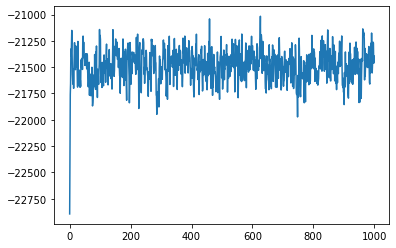

In [27]:
plt.plot(energies)
plt.show()


# Run vanilla MD on ala dipeptide at lambda = 1.0

In [2]:
with open("8mer_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions
    box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()



In [3]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 1
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

# print(compound_thermodynamic_state.lambda_rest_bonds)
# print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
# print(compound_thermodynamic_state.lambda_alchemical_bonds_new)
# print(compound_thermodynamic_state.lambda_alchemical_electrostatics_reciprocal)
# print(compound_thermodynamic_state.lambda_alchemical_sterics_old)
# print(compound_thermodynamic_state.lambda_alchemical_sterics_exceptions_old)
# print(compound_thermodynamic_state.lambda_alchemical_sterics_new)
# print(compound_thermodynamic_state.lambda_alchemical_sterics_exceptions_new)

In [4]:
# compound_thermodynamic_state.lambda_alchemical_electrostatics_reciprocal = 0
# compound_thermodynamic_state.lambda_alchemical_electrostatics_new = 0
# compound_thermodynamic_state.lambda_alchemical_electrostatics_exceptions_new = 0
# compound_thermodynamic_state.lambda_alchemical_sterics_new = 0
# compound_thermodynamic_state.lambda_alchemical_sterics_exceptions_new = 0

In [10]:
# Get energy
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [11]:
for k, v in context.getParameters().items():
    print(k, v)

MonteCarloPressure 1.01325
MonteCarloTemperature 300.0
lambda_alchemical_angles_new 1.0
lambda_alchemical_angles_old 0.0
lambda_alchemical_bonds_new 1.0
lambda_alchemical_bonds_old 0.0
lambda_alchemical_electrostatics_exceptions_new 1.0
lambda_alchemical_electrostatics_exceptions_old 0.0
lambda_alchemical_electrostatics_new 1.0
lambda_alchemical_electrostatics_old 0.0
lambda_alchemical_electrostatics_reciprocal 1.0
lambda_alchemical_sterics_exceptions_new 1.0
lambda_alchemical_sterics_exceptions_old 0.0
lambda_alchemical_sterics_new 1.0
lambda_alchemical_sterics_old 0.0
lambda_alchemical_torsions_new 1.0
lambda_alchemical_torsions_old 0.0
lambda_rest_angles 1.0
lambda_rest_bonds 1.0
lambda_rest_electrostatics 1.0
lambda_rest_electrostatics_exceptions 1.0
lambda_rest_sterics 1.0
lambda_rest_sterics_exceptions 1.0
lambda_rest_torsions 1.0


In [12]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [13]:
energies, positions_old, positions_new = [], [], []

# for _ in tqdm_notebook(range(1000)):
#     integrator.step(250) 

for step in tqdm_notebook(range(250000)):
    integrator.step(1) 
    
#     if step > 32450:
    
#         # Get energy and positions
#         state = context.getState(getEnergy=True, getPositions=True)
#         energies.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
#         pos = state.getPositions(asNumpy=True)
#         old_pos = np.asarray(htf.old_positions(pos))
#         new_pos = np.asarray(htf.new_positions(pos))
#         positions_old.append(old_pos)
#         positions_new.append(new_pos)


/scratch/lsftmp/4057976.tmpdir/ipykernel_46237/174851586.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm_notebook(range(250000)):


  0%|          | 0/250000 [00:00<?, ?it/s]

OpenMMException: Particle coordinate is nan

In [6]:
htf._atom_classes['core_atoms']

{6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42}

In [9]:
for atom in htf.hybrid_topology.atoms:
    print(atom.index, atom)

0 ACE0-CH3
1 ACE0-C
2 ACE0-O
3 ACE0-H1
4 ACE0-H2
5 ACE0-H3
6 SER1-N
7 SER1-CA
8 SER1-C
9 SER1-O
10 SER1-CB
11 SER1-OG
12 SER1-H2
13 SER1-HA
14 SER1-HB3
15 SER1-HB2
16 SER1-HG
17 ALA2-N
18 ALA2-CA
19 ALA2-C
20 ALA2-O
21 ALA2-CB
22 ALA2-H
23 ALA2-HA
24 ALA2-HB1
25 ALA2-HB2
26 ALA2-HB3
5575 ALA2-HB
5576 ALA2-CG2
5577 ALA2-HG21
5578 ALA2-HG22
5579 ALA2-HG23
5580 ALA2-OG1
5581 ALA2-HG1
27 VAL3-N
28 VAL3-CA
29 VAL3-C
30 VAL3-O
31 VAL3-CB
32 VAL3-CG1
33 VAL3-CG2
34 VAL3-H
35 VAL3-HA
36 VAL3-HB
37 VAL3-HG11
38 VAL3-HG12
39 VAL3-HG13
40 VAL3-HG21
41 VAL3-HG22
42 VAL3-HG23
43 LEU4-N
44 LEU4-CA
45 LEU4-C
46 LEU4-O
47 LEU4-CB
48 LEU4-CG
49 LEU4-CD1
50 LEU4-CD2
51 LEU4-H
52 LEU4-HA
53 LEU4-HB3
54 LEU4-HB2
55 LEU4-HG
56 LEU4-HD11
57 LEU4-HD12
58 LEU4-HD13
59 LEU4-HD21
60 LEU4-HD22
61 LEU4-HD23
62 GLN5-N
63 GLN5-CA
64 GLN5-C
65 GLN5-O
66 GLN5-CB
67 GLN5-CG
68 GLN5-CD
69 GLN5-NE2
70 GLN5-OE1
71 GLN5-H
72 GLN5-HA
73 GLN5-HB3
74 GLN5-HB2
75 GLN5-HG3
76 GLN5-HG2
77 GLN5-HE22
78 GLN5-HE21
79 SER6-N
80 SER

1442 HOH454-H2
1443 HOH455-O
1444 HOH455-H1
1445 HOH455-H2
1446 HOH456-O
1447 HOH456-H1
1448 HOH456-H2
1449 HOH457-O
1450 HOH457-H1
1451 HOH457-H2
1452 HOH458-O
1453 HOH458-H1
1454 HOH458-H2
1455 HOH459-O
1456 HOH459-H1
1457 HOH459-H2
1458 HOH460-O
1459 HOH460-H1
1460 HOH460-H2
1461 HOH461-O
1462 HOH461-H1
1463 HOH461-H2
1464 HOH462-O
1465 HOH462-H1
1466 HOH462-H2
1467 HOH463-O
1468 HOH463-H1
1469 HOH463-H2
1470 HOH464-O
1471 HOH464-H1
1472 HOH464-H2
1473 HOH465-O
1474 HOH465-H1
1475 HOH465-H2
1476 HOH466-O
1477 HOH466-H1
1478 HOH466-H2
1479 HOH467-O
1480 HOH467-H1
1481 HOH467-H2
1482 HOH468-O
1483 HOH468-H1
1484 HOH468-H2
1485 HOH469-O
1486 HOH469-H1
1487 HOH469-H2
1488 HOH470-O
1489 HOH470-H1
1490 HOH470-H2
1491 HOH471-O
1492 HOH471-H1
1493 HOH471-H2
1494 HOH472-O
1495 HOH472-H1
1496 HOH472-H2
1497 HOH473-O
1498 HOH473-H1
1499 HOH473-H2
1500 HOH474-O
1501 HOH474-H1
1502 HOH474-H2
1503 HOH475-O
1504 HOH475-H1
1505 HOH475-H2
1506 HOH476-O
1507 HOH476-H1
1508 HOH476-H2
1509 HOH477-O
151

2942 HOH955-H2
2943 HOH956-O
2944 HOH956-H1
2945 HOH956-H2
2946 HOH957-O
2947 HOH957-H1
2948 HOH957-H2
2949 HOH958-O
2950 HOH958-H1
2951 HOH958-H2
2952 HOH959-O
2953 HOH959-H1
2954 HOH959-H2
2955 HOH960-O
2956 HOH960-H1
2957 HOH960-H2
2958 HOH961-O
2959 HOH961-H1
2960 HOH961-H2
2961 HOH962-O
2962 HOH962-H1
2963 HOH962-H2
2964 HOH963-O
2965 HOH963-H1
2966 HOH963-H2
2967 HOH964-O
2968 HOH964-H1
2969 HOH964-H2
2970 HOH965-O
2971 HOH965-H1
2972 HOH965-H2
2973 HOH966-O
2974 HOH966-H1
2975 HOH966-H2
2976 HOH967-O
2977 HOH967-H1
2978 HOH967-H2
2979 HOH968-O
2980 HOH968-H1
2981 HOH968-H2
2982 HOH969-O
2983 HOH969-H1
2984 HOH969-H2
2985 HOH970-O
2986 HOH970-H1
2987 HOH970-H2
2988 HOH971-O
2989 HOH971-H1
2990 HOH971-H2
2991 HOH972-O
2992 HOH972-H1
2993 HOH972-H2
2994 HOH973-O
2995 HOH973-H1
2996 HOH973-H2
2997 HOH974-O
2998 HOH974-H1
2999 HOH974-H2
3000 HOH975-O
3001 HOH975-H1
3002 HOH975-H2
3003 HOH976-O
3004 HOH976-H1
3005 HOH976-H2
3006 HOH977-O
3007 HOH977-H1
3008 HOH977-H2
3009 HOH978-O
301

4442 HOH1458-H2
4443 HOH1459-O
4444 HOH1459-H1
4445 HOH1459-H2
4446 HOH1460-O
4447 HOH1460-H1
4448 HOH1460-H2
4449 HOH1461-O
4450 HOH1461-H1
4451 HOH1461-H2
4452 HOH1462-O
4453 HOH1462-H1
4454 HOH1462-H2
4455 HOH1463-O
4456 HOH1463-H1
4457 HOH1463-H2
4458 HOH1464-O
4459 HOH1464-H1
4460 HOH1464-H2
4461 HOH1465-O
4462 HOH1465-H1
4463 HOH1465-H2
4464 HOH1466-O
4465 HOH1466-H1
4466 HOH1466-H2
4467 HOH1467-O
4468 HOH1467-H1
4469 HOH1467-H2
4470 HOH1468-O
4471 HOH1468-H1
4472 HOH1468-H2
4473 HOH1469-O
4474 HOH1469-H1
4475 HOH1469-H2
4476 HOH1470-O
4477 HOH1470-H1
4478 HOH1470-H2
4479 HOH1471-O
4480 HOH1471-H1
4481 HOH1471-H2
4482 HOH1472-O
4483 HOH1472-H1
4484 HOH1472-H2
4485 HOH1473-O
4486 HOH1473-H1
4487 HOH1473-H2
4488 HOH1474-O
4489 HOH1474-H1
4490 HOH1474-H2
4491 HOH1476-O
4492 HOH1476-H1
4493 HOH1476-H2
4494 HOH1477-O
4495 HOH1477-H1
4496 HOH1477-H2
4497 HOH1478-O
4498 HOH1478-H1
4499 HOH1478-H2
4500 HOH1479-O
4501 HOH1479-H1
4502 HOH1479-H2
4503 HOH1480-O
4504 HOH1480-H1
4505 HOH1480-

In [7]:
htf._atom_classes['unique_old_atoms']

{24, 25, 26}

In [8]:
htf._atom_classes['unique_new_atoms']

{5575, 5576, 5577, 5578, 5579, 5580, 5581}

In [48]:
with open("ala_lambda_1_energies.npy", "wb") as f:
    np.save(f, energies)

with open("ala_lambda_1_old.npy", "wb") as f:
    np.save(f, positions_old)

with open("ala_lambda_1_new.npy", "wb") as f:
    np.save(f, positions_new)
    

In [24]:
with open("ala_lambda_1_energies.npy", "rb") as f:
    energies = np.load(f)

with open("ala_lambda_1_old.npy", "rb") as f:
    positions_old = np.load(f)

with open("ala_lambda_1_new.npy", "rb") as f:
    positions_new = np.load(f)
    

In [65]:
htf._atom_classes['unique_old_atoms']

{11, 12, 13}

In [66]:
htf._atom_classes['unique_new_atoms']

{1557, 1558, 1559, 1560, 1561, 1562, 1563}

In [71]:
htf._atom_classes['core_atoms']

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 21}

In [73]:
htf._rest_region

[4,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 1557,
 1558,
 1559,
 1560,
 1561,
 1562,
 1563,
 16,
 17]

In [69]:
for i in {1557, 1558, 1559, 1560, 1561, 1562, 1563}:
    print(htf._hybrid_to_new_map[i])

13
14
15
16
17
18
19


In [27]:
for i, p in enumerate(positions_old[832]):
    print(i, p)

0 [1.13244556 0.55652141 2.28663996]
1 [1.07900205 0.55184162 2.38152352]
2 [1.14033025 0.53751803 2.47048804]
3 [1.00806764 0.47122096 2.36282544]
4 [0.99862295 0.67587739 2.37895184]
5 [1.06399186 0.77622366 2.42303299]
6 [0.87201025 0.6959791  2.35896365]
7 [0.81766082 0.61102317 2.36440683]
8 [0.79702673 0.81253633 2.35865006]
9 [0.81027485 0.86085295 2.26184618]
10 [1.30564917e+26 7.51942798e+25 1.26121162e+26]
11 [-9.22637897e+25 -5.17155748e+25 -1.01902633e+26]
12 [ 3.39410124e+24  2.24396021e+24 -1.03258254e+24]
13 [ 1.12894740e+24  5.70800545e+23 -8.12762078e+22]
14 [0.81609392 0.91399081 2.4773637 ]
15 [0.80949508 0.85503738 2.59131094]
16 [0.85082855 1.03839137 2.4278299 ]
17 [0.85786114 1.07979988 2.33597742]
18 [0.89158322 1.14102202 2.52581924]
19 [0.88482796 1.23914705 2.47884217]
20 [0.80987499 1.14876232 2.59754687]
21 [0.98688678 1.14034972 2.57871328]
22 [0.55492722 1.41952702 1.35984498]
23 [0.62076201 1.36345472 1.40088151]
24 [0.51920492 1.47133732 1.43196937]
25 

423 [0.55878392 2.17585323 0.12968659]
424 [0.73946254 0.01032132 0.52658724]
425 [0.79322403 0.08381294 0.49707449]
426 [ 0.76248118 -0.06146297  0.46760017]
427 [0.89244473 1.98759211 2.25876514]
428 [0.96767704 1.96387939 2.20454222]
429 [0.82184757 2.00365808 2.19615328]
430 [1.54702671 1.88341211 0.61967255]
431 [1.55286626 1.94982732 0.5509904 ]
432 [1.47113983 1.83037212 0.5953773 ]
433 [2.18256765 0.11417126 1.49627773]
434 [2.23254705 0.07377302 1.42533861]
435 [2.24169924 0.11206541 1.57151959]
436 [2.42932701 1.76947945 2.28033408]
437 [2.48696664 1.84589492 2.28115116]
438 [2.3432856  1.80406473 2.30406282]
439 [1.32749241 1.34154441 0.92828631]
440 [1.42219241 1.34425789 0.94195616]
441 [1.31485005 1.37783424 0.84061911]
442 [2.35254719 2.29678607 0.73205192]
443 [2.38491875 2.21918414 0.77779402]
444 [2.28460324 2.33195336 0.78957757]
445 [0.41600909 0.71030759 0.53509163]
446 [0.45574226 0.63233657 0.49630872]
447 [0.3343544  0.72227912 0.48659925]
448 [1.1808086 0.06994

821 [2.52628626 1.30553988 1.54140418]
822 [2.44051475 1.28395763 1.41853675]
823 [2.43365249 0.67038118 2.45380564]
824 [2.39376154 0.59417176 2.41181571]
825 [2.38109834 0.68466082 2.53252331]
826 [1.6510179  2.40003947 1.32398156]
827 [1.7055763  2.47780624 1.31223299]
828 [1.65378618 2.38277584 1.41809119]
829 [1.08229673 1.64619139 0.38986512]
830 [1.07488426 1.61178476 0.47887948]
831 [0.99327477 1.67289524 0.36696724]
832 [1.32763149 2.24597014 1.02058989]
833 [1.37323634 2.23579047 1.10412964]
834 [1.39745945 2.26041431 0.9567327 ]
835 [0.48291499 0.95656756 0.23323234]
836 [0.51894315 0.92878282 0.31744813]
837 [0.50838492 1.04850291 0.22539067]
838 [1.04076303 0.88539918 0.98229956]
839 [1.09087568 0.92396486 1.05415865]
840 [0.95553895 0.92877727 0.98648471]
841 [1.87512812 2.18254422 0.90853166]
842 [1.9616881  2.15119097 0.93473588]
843 [1.87721784 2.18160318 0.81283911]
844 [1.7853231  2.22317416 0.2818736 ]
845 [1.87648134 2.24663352 0.26449108]
846 [1.73438587 2.2814756

1209 [0.47170689 2.04217155 1.05407389]
1210 [2.48982272 0.62268058 1.46215313]
1211 [2.53683264 0.5445552  1.43301877]
1212 [2.55552828 0.69226581 1.46042315]
1213 [2.2434655  1.94099469 1.91076932]
1214 [2.1914622  1.94022667 1.99112717]
1215 [2.18287005 1.97154095 1.84326054]
1216 [2.01943506 2.37088066 0.18706711]
1217 [2.09630423 2.40729422 0.1431638 ]
1218 [1.94503857 2.40503471 0.13745883]
1219 [0.16639804 0.37083309 1.97602643]
1220 [0.21060281 0.43208068 2.03482261]
1221 [0.13284704 0.30218956 2.03368677]
1222 [2.47924943 0.11892718 0.91689679]
1223 [2.41492357 0.08615636 0.85404319]
1224 [2.50401117 0.20503335 0.88320846]
1225 [1.57235021 1.7708683  2.38175064]
1226 [1.54300441 1.74760845 2.29365909]
1227 [1.63328627 1.70112692 2.40594268]
1228 [1.03194551 2.13266013 0.7909011 ]
1229 [1.05118656 2.21564359 0.7472451 ]
1230 [0.94507843 2.10829507 0.75892028]
1231 [1.55635806 2.06567837 0.38152625]
1232 [1.64549679 2.08874149 0.35535952]
1233 [1.50514408 2.07260488 0.30095659]


In [29]:
for i, p in enumerate(positions_new[832]):
    print(i, p)

0 [1.13244556 0.55652141 2.28663996]
1 [1.07900205 0.55184162 2.38152352]
2 [1.14033025 0.53751803 2.47048804]
3 [1.00806764 0.47122096 2.36282544]
4 [0.99862295 0.67587739 2.37895184]
5 [1.06399186 0.77622366 2.42303299]
6 [0.87201025 0.6959791  2.35896365]
7 [0.81766082 0.61102317 2.36440683]
8 [0.79702673 0.81253633 2.35865006]
9 [0.81027485 0.86085295 2.26184618]
10 [1.30564917e+26 7.51942798e+25 1.26121162e+26]
11 [0.81609392 0.91399081 2.4773637 ]
12 [0.80949508 0.85503738 2.59131094]
13 [-1.12927482e+25 -8.13404716e+24  7.35358989e+24]
14 [0.53673474 0.88842214 2.37766388]
15 [0.53140873 0.95805274 2.2939727 ]
16 [0.43442031 0.85320882 2.39080847]
17 [0.56240491 0.95406674 2.4608073 ]
18 [0.60701936 0.69202515 2.25516227]
19 [0.66658881 0.70323787 2.18071929]
20 [0.85082855 1.03839137 2.4278299 ]
21 [0.85786114 1.07979988 2.33597742]
22 [0.89158322 1.14102202 2.52581924]
23 [0.88482796 1.23914705 2.47884217]
24 [0.80987499 1.14876232 2.59754687]
25 [0.98688678 1.14034972 2.57871

421 [0.92782396 0.63257655 0.28987714]
422 [0.09706791 1.98419343 1.8023994 ]
423 [0.12827421 1.97804777 1.71211809]
424 [0.03534278 2.05734785 1.80152837]
425 [0.52631162 2.08758261 0.11190553]
426 [0.53821378 2.04055773 0.19442413]
427 [0.55878392 2.17585323 0.12968659]
428 [0.73946254 0.01032132 0.52658724]
429 [0.79322403 0.08381294 0.49707449]
430 [ 0.76248118 -0.06146297  0.46760017]
431 [0.89244473 1.98759211 2.25876514]
432 [0.96767704 1.96387939 2.20454222]
433 [0.82184757 2.00365808 2.19615328]
434 [1.54702671 1.88341211 0.61967255]
435 [1.55286626 1.94982732 0.5509904 ]
436 [1.47113983 1.83037212 0.5953773 ]
437 [2.18256765 0.11417126 1.49627773]
438 [2.23254705 0.07377302 1.42533861]
439 [2.24169924 0.11206541 1.57151959]
440 [2.42932701 1.76947945 2.28033408]
441 [2.48696664 1.84589492 2.28115116]
442 [2.3432856  1.80406473 2.30406282]
443 [1.32749241 1.34154441 0.92828631]
444 [1.42219241 1.34425789 0.94195616]
445 [1.31485005 1.37783424 0.84061911]
446 [2.35254719 2.2967

800 [2.03548705 1.39863302 1.72039537]
801 [2.08945822 1.32542412 1.69056438]
802 [1.96609367 1.35776978 1.7721358 ]
803 [0.8524357 1.1238707 1.8009931]
804 [0.85461964 1.03663085 1.84032194]
805 [0.84389877 1.18351777 1.87536827]
806 [0.09224767 1.60001699 0.42697584]
807 [0.0610547  1.53337185 0.36575703]
808 [0.13182912 1.66708419 0.3713196 ]
809 [1.23149679 2.38105335 0.39167391]
810 [1.25905424 2.29401986 0.42045023]
811 [1.31259425 2.42426283 0.36486977]
812 [0.26585873 1.39728323 2.23217298]
813 [0.18769289 1.39415134 2.17701311]
814 [0.31861045 1.32281485 2.20329332]
815 [0.81105151 2.32480163 0.35432758]
816 [0.87470489 2.35779577 0.29090872]
817 [0.82978034 2.23114299 0.36062104]
818 [0.5595599  1.32539323 2.48353714]
819 [0.6310016  1.3877073  2.47029481]
820 [0.53523342 1.29764951 2.39521485]
821 [2.44229907 2.21321337 0.44742218]
822 [2.40094551 2.28127429 0.39431935]
823 [2.46180433 2.25625923 0.5306623 ]
824 [2.47121776 1.24036064 1.49802855]
825 [2.52628626 1.30553988 1

1209 [0.08240039 2.53009602 0.59256829]
1210 [0.0371041  2.41234611 0.67624718]
1211 [0.55762205 2.01601308 1.02095836]
1212 [0.61774434 2.03423669 1.09317698]
1213 [0.47170689 2.04217155 1.05407389]
1214 [2.48982272 0.62268058 1.46215313]
1215 [2.53683264 0.5445552  1.43301877]
1216 [2.55552828 0.69226581 1.46042315]
1217 [2.2434655  1.94099469 1.91076932]
1218 [2.1914622  1.94022667 1.99112717]
1219 [2.18287005 1.97154095 1.84326054]
1220 [2.01943506 2.37088066 0.18706711]
1221 [2.09630423 2.40729422 0.1431638 ]
1222 [1.94503857 2.40503471 0.13745883]
1223 [0.16639804 0.37083309 1.97602643]
1224 [0.21060281 0.43208068 2.03482261]
1225 [0.13284704 0.30218956 2.03368677]
1226 [2.47924943 0.11892718 0.91689679]
1227 [2.41492357 0.08615636 0.85404319]
1228 [2.50401117 0.20503335 0.88320846]
1229 [1.57235021 1.7708683  2.38175064]
1230 [1.54300441 1.74760845 2.29365909]
1231 [1.63328627 1.70112692 2.40594268]
1232 [1.03194551 2.13266013 0.7909011 ]
1233 [1.05118656 2.21564359 0.7472451 ]


In [81]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom.index, atom)

0 <Atom 0 (H1) of chain 0 residue 0 (ACE)>
1 <Atom 1 (CH3) of chain 0 residue 0 (ACE)>
2 <Atom 2 (H2) of chain 0 residue 0 (ACE)>
3 <Atom 3 (H3) of chain 0 residue 0 (ACE)>
4 <Atom 4 (C) of chain 0 residue 0 (ACE)>
5 <Atom 5 (O) of chain 0 residue 0 (ACE)>
6 <Atom 6 (N) of chain 0 residue 1 (THR)>
7 <Atom 7 (H) of chain 0 residue 1 (THR)>
8 <Atom 8 (CA) of chain 0 residue 1 (THR)>
9 <Atom 9 (HA) of chain 0 residue 1 (THR)>
10 <Atom 10 (CB) of chain 0 residue 1 (THR)>
11 <Atom 11 (C) of chain 0 residue 1 (THR)>
12 <Atom 12 (O) of chain 0 residue 1 (THR)>
13 <Atom 13 (HB) of chain 0 residue 1 (THR)>
14 <Atom 14 (CG2) of chain 0 residue 1 (THR)>
15 <Atom 15 (HG21) of chain 0 residue 1 (THR)>
16 <Atom 16 (HG22) of chain 0 residue 1 (THR)>
17 <Atom 17 (HG23) of chain 0 residue 1 (THR)>
18 <Atom 18 (OG1) of chain 0 residue 1 (THR)>
19 <Atom 19 (HG1) of chain 0 residue 1 (THR)>
20 <Atom 20 (N) of chain 0 residue 2 (NME)>
21 <Atom 21 (H) of chain 0 residue 2 (NME)>
22 <Atom 22 (C) of chain 0 r

In [57]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom.index, atom)

0 <Atom 0 (H1) of chain 0 residue 0 (ACE)>
1 <Atom 1 (CH3) of chain 0 residue 0 (ACE)>
2 <Atom 2 (H2) of chain 0 residue 0 (ACE)>
3 <Atom 3 (H3) of chain 0 residue 0 (ACE)>
4 <Atom 4 (C) of chain 0 residue 0 (ACE)>
5 <Atom 5 (O) of chain 0 residue 0 (ACE)>
6 <Atom 6 (N) of chain 0 residue 1 (ALA)>
7 <Atom 7 (H) of chain 0 residue 1 (ALA)>
8 <Atom 8 (CA) of chain 0 residue 1 (ALA)>
9 <Atom 9 (HA) of chain 0 residue 1 (ALA)>
10 <Atom 10 (CB) of chain 0 residue 1 (ALA)>
11 <Atom 11 (HB1) of chain 0 residue 1 (ALA)>
12 <Atom 12 (HB2) of chain 0 residue 1 (ALA)>
13 <Atom 13 (HB3) of chain 0 residue 1 (ALA)>
14 <Atom 14 (C) of chain 0 residue 1 (ALA)>
15 <Atom 15 (O) of chain 0 residue 1 (ALA)>
16 <Atom 16 (N) of chain 0 residue 2 (NME)>
17 <Atom 17 (H) of chain 0 residue 2 (NME)>
18 <Atom 18 (C) of chain 0 residue 2 (NME)>
19 <Atom 19 (H1) of chain 0 residue 2 (NME)>
20 <Atom 20 (H2) of chain 0 residue 2 (NME)>
21 <Atom 21 (H3) of chain 0 residue 2 (NME)>
22 <Atom 22 (O) of chain 1 residue 

1526 <Atom 1526 (H1) of chain 1 residue 504 (HOH)>
1527 <Atom 1527 (H2) of chain 1 residue 504 (HOH)>
1528 <Atom 1528 (O) of chain 1 residue 505 (HOH)>
1529 <Atom 1529 (H1) of chain 1 residue 505 (HOH)>
1530 <Atom 1530 (H2) of chain 1 residue 505 (HOH)>
1531 <Atom 1531 (O) of chain 1 residue 506 (HOH)>
1532 <Atom 1532 (H1) of chain 1 residue 506 (HOH)>
1533 <Atom 1533 (H2) of chain 1 residue 506 (HOH)>
1534 <Atom 1534 (O) of chain 1 residue 507 (HOH)>
1535 <Atom 1535 (H1) of chain 1 residue 507 (HOH)>
1536 <Atom 1536 (H2) of chain 1 residue 507 (HOH)>
1537 <Atom 1537 (O) of chain 1 residue 508 (HOH)>
1538 <Atom 1538 (H1) of chain 1 residue 508 (HOH)>
1539 <Atom 1539 (H2) of chain 1 residue 508 (HOH)>
1540 <Atom 1540 (O) of chain 1 residue 509 (HOH)>
1541 <Atom 1541 (H1) of chain 1 residue 509 (HOH)>
1542 <Atom 1542 (H2) of chain 1 residue 509 (HOH)>
1543 <Atom 1543 (O) of chain 1 residue 510 (HOH)>
1544 <Atom 1544 (H1) of chain 1 residue 510 (HOH)>
1545 <Atom 1545 (H2) of chain 1 resid

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

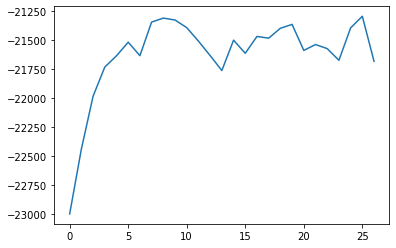

In [8]:
plt.plot(energies)
plt.show()


## Generate dcds

In [51]:
with open("ala_lambda_1_old.npy", 'rb') as f:
    old = np.load(f)

traj = md.Trajectory(np.array(old), md.Topology.from_openmm(htf._topology_proposal.old_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 887, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_1_old.dcd")
traj[0].save("ala_lambda_1_old.pdb")

In [52]:
with open("ala_lambda_1_new.npy", 'rb') as f:
    new = np.load(f)

traj = md.Trajectory(np.array(new), md.Topology.from_openmm(htf._topology_proposal.new_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 887, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_1_new.dcd")
traj[0].save("ala_lambda_1_new.pdb")

In [ ]:
with open("ala_lambda_0.5_old.npy", 'rb') as f:
    old = np.load(f)

traj = md.Trajectory(np.array(old), md.Topology.from_openmm(htf._topology_proposal.old_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 1000, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_0.5_old.dcd")
traj[0].save("ala_lambda_0.5_old.pdb")

In [ ]:
with open("ala_lambda_0.5_new.npy", 'rb') as f:
    new = np.load(f)

traj = md.Trajectory(np.array(new), md.Topology.from_openmm(htf._topology_proposal.new_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 1000, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_0.5_new.dcd")
traj[0].save("ala_lambda_0.5_new.pdb")